# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [ ]:
!pip install tensorflow-gpu
!pip install catboost
# аугментации изображений
!pip install albumentations - q
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python

     |████████████████████████████████| 394.3MB 40kB/s 
     |████████████████████████████████| 67.3MB 57kB/s 
     |████████████████████████████████| 634kB 4.3MB/s 
     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 8.2MB 5.2MB/s 
     |████████████████████████████████| 7.1MB 3.6MB/s 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pymorphy2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import albumentations

# plt
import matplotlib.pyplot as plt
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6754210857226321736
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11140623232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14359306952477746630
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.10 (default, Feb 20 2021, 21:17:23) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/ColabNotebooks/CarPrice/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [ ]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [ ]:
train.head(20)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый
5,седан,MERCEDES,чёрный,Автомобиль в очень хорошем состоянии. Бережная...,1.8 LTR,184 N12,бензин,229000,2006,C_KLASSE,200 1.8 AT (184 л.с.),4,550000.0,2007,1049987852,SEDAN AUTOMATIC 1.8,автоматическая,3 или более,6 лет и 9 месяцев,Оригинал,задний,Левый
6,седан,MERCEDES,чёрный,НОВЫЙ АВТОМОБИЛЬ!!!\nАВТОМОБИЛЬ НЕ СТАНОВИЛСЯ ...,2.0 LTR,197 N12,бензин,50,2016,E_KLASSE,200 2.0 AT (197 л.с.) 4WD,4,3170000.0,2020,1099934465,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
7,седан,BMW,чёрный,Идеальное состояние салона и кузова. Не требуе...,3.0 LTR,326 N12,бензин,90000,2015,7ER,740Li xDrive 3.0 AT (326 л.с.) 4WD,4,2900000.0,2016,1098936372,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,4 года и 3 месяца,Оригинал,полный,Левый
8,седан,AUDI,чёрный,Автомобиль технически полностью исправен и обс...,1.8 LTR,190 N12,бензин,87000,2014,A6,1.8 AMT (190 л.с.),4,1290000.0,2015,1097391980,SEDAN ROBOT 1.8,роботизированная,2 владельца,NaN,Оригинал,передний,Левый
9,лифтбек,BMW,синий,"Разносторонний характер, объединяющий в себе р...",2.0 LTR,184 N12,дизель,171644,2011,3ER,320d xDrive 2.0d AT (184 л.с.) 4WD,5,1427000.0,2014,1099563408,LIFTBACK AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [ ]:
# split данных
data_train, data_test = train_test_split(
    train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

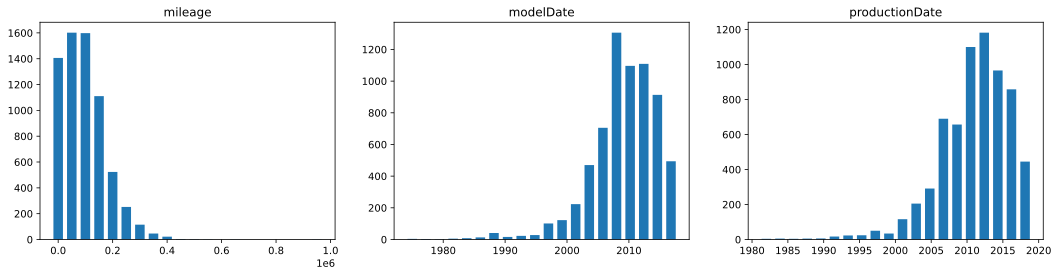

In [ ]:
# посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [ ]:
# используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
                        'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

# используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

# Столбцы которые мы преобразуем в числовые признаки
cat_in_numerical = ['Владельцы', 'Владение',
                    'enginePower', 'engineDisplacement']

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


## Посмотрим на количество пустых значений в датасете 

Имеем пустые значения только в двух столбцах 
- Владельцы 1 (можно заменить на случайное количество влаельцев сильно на датасет это не повлияет)
- Владение 5418 (произведем замену на значение равное отношению возрасту автомобилю к количеству владельцев с учетом что все владельцы владели автомобилем равное количество времени)

In [ ]:
# Функция для определения количества нулевых знчений
def NaN_Sum(col): return col.isnull().sum()


columns = list(data.columns)
for col in columns:
    print("Количество пустых значений", col, NaN_Sum(data[col]), sep=' ')

Количество пустых значений bodyType 0
Количество пустых значений brand 0
Количество пустых значений color 0
Количество пустых значений description 0
Количество пустых значений engineDisplacement 0
Количество пустых значений enginePower 0
Количество пустых значений fuelType 0
Количество пустых значений mileage 0
Количество пустых значений modelDate 0
Количество пустых значений model_info 0
Количество пустых значений name 0
Количество пустых значений numberOfDoors 0
Количество пустых значений productionDate 0
Количество пустых значений sell_id 0
Количество пустых значений vehicleConfiguration 0
Количество пустых значений vehicleTransmission 0
Количество пустых значений Владельцы 1
Количество пустых значений Владение 5418
Количество пустых значений ПТС 0
Количество пустых значений Привод 0
Количество пустых значений Руль 0
Количество пустых значений sample 0
Количество пустых значений price 0


## Столбцы которые мы преобразуем в числовые признаки

In [ ]:
# cat_in_numerical=['Владельцы','Владение','enginePower','engineDisplacement']

# Преобразуем значения мощности в числовой признак (лошадиные силы)
df = data.copy()


def enginePower_to_numeric(data):
    result = int(data['enginePower'][:3])
    return result


# Преобразуем значения мощности в числовой признак (объем двигателя)
def engineDisplacement_to_numeric(Data):
    try:
        pattern = re.compile('\d.\d')
        result = float(pattern.search(Data['engineDisplacement'])[0])
        return result
    except:
        return random.uniform(1.8, 3.5)

# Преобразуем значения количества владельцев в числовой признак


def owners_to_int(Data):
    try:
        pattern = re.compile('\d')
        result = int(pattern.match(Data['Владельцы'])[0])
        return result
    except:
        return 1

# Преобразуем значения времени владения автомобилем в числовой признак


def ownership_to_float(Data):
    try:
        pattern = re.compile('\d')
        result = float('.'.join(pattern.findall(Data['Владение'])))
        return result
    except:
        return (2020-Data['productionDate'])/Data['Владельцы']


def create_xDrive(Data):
    try:
        pattern = re.compile('x[A-Z][a-z]*')
        result = pattern.search(Data['name'])[0]
        if result == 'xDrive':
            return 'yes'
        else:
            return 'no'
    except:
        return 'no'


df['xdrive'] = df.apply(lambda df: create_xDrive(df), axis=1)
df['enginePower'] = df.apply(lambda df: enginePower_to_numeric(df), axis=1)
df['engineDisplacement'] = df.apply(
    lambda df: engineDisplacement_to_numeric(df), axis=1)
df['Владельцы'] = df.apply(lambda df: owners_to_int(df), axis=1)
df['Владение'] = df.apply(lambda df: ownership_to_float(df), axis=1)

In [ ]:
df.head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,xdrive
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3,6.3,Оригинал,задний,Левый,0,0.0,no
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,313,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1,6.6,Оригинал,полный,Левый,0,0.0,yes
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3,4.0,Оригинал,полный,Левый,0,0.0,no
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0,136,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2,6.5,Оригинал,задний,Левый,0,0.0,no
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0,190,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1,1.0,Оригинал,полный,Левый,0,0.0,yes


## Внесем изменения в список признаков 

In [ ]:
# используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color',  'fuelType', 'model_info',
                        'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'xdrive']

# используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'Владельцы', 'Владение',
                      'enginePower', 'engineDisplacement']

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id', 'name'], axis=1, inplace=True)

    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    # for column in numerical_features:
    #    df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # На данном шаге в датафрейме df уже нет пропусков и мы можем не вносить изменения

    # Прологирифтируем некоторые столбцы
    #numerical_features_log = ['mileage', 'modelDate', 'productionDate']
    # for l in numerical_features_log:
    #df_output[l] = np.log(df_output[l])

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код на Encoding фитчей
    # ....

    # ################### Feature Engineering ####################################################
    # тут ваш код на генерацию новых фитчей
    # новые фичи были добавлены на прошлом шаге, дублировать сюда не вижу смысла

    # ################### Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    df_output.drop(['vehicleConfiguration'], axis=1, inplace=True)

    return df_output

## Благодаря предъобработке признаков удалось сократить количество столбцов после One Hot Encoding на 383

In [ ]:
df_preproc = preproc_data(df)
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 188 entries, engineDisplacement to xdrive_1
dtypes: float64(8), int64(1), uint8(179)
memory usage: 2.0 MB


## Split data

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 187 entries, engineDisplacement to xdrive_1
dtypes: float64(8), uint8(179)
memory usage: 409.6 KB


# Model 2: CatBoostRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
X_train

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владельцы,Владение,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,...,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,xdrive_0,xdrive_1
7320,0.898305,0.7504,0.149999,0.770833,0.763158,0.0,0.261111,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0
8037,0.220339,0.2720,0.020941,0.937500,0.947368,0.0,0.055556,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0
4681,0.406780,0.2880,0.133896,0.687500,0.631579,1.0,0.129630,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0
6014,0.186441,0.1744,0.329999,0.729167,0.657895,1.0,0.186111,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0
3649,0.389831,0.3808,0.125999,0.833333,0.815789,0.0,0.183333,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,0.389831,0.2784,0.089687,0.916667,0.894737,1.0,0.102778,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0
6862,0.220339,0.1744,0.014378,0.958333,0.973684,0.0,0.027778,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1
6897,0.389831,0.2720,0.120999,0.812500,0.763158,1.0,0.083333,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,0
7061,0.389831,0.2784,0.112999,0.916667,0.921053,0.0,0.088889,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0


In [ ]:
model = CatBoostRegressor(iterations=5000,
                          # depth=10,
                          learning_rate=0.11,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          # task_type='GPU',
                          )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9206328	test: 0.9429972	best: 0.9429972 (0)	total: 52.1ms	remaining: 4m 20s
100:	learn: 0.1754707	test: 0.1737377	best: 0.1737377 (100)	total: 488ms	remaining: 23.7s
200:	learn: 0.1461303	test: 0.1490079	best: 0.1490011 (199)	total: 800ms	remaining: 19.1s
300:	learn: 0.1325634	test: 0.1386412	best: 0.1386022 (297)	total: 1.18s	remaining: 18.4s
400:	learn: 0.1226948	test: 0.1330823	best: 0.1330517 (399)	total: 1.49s	remaining: 17.1s
500:	learn: 0.1157992	test: 0.1295008	best: 0.1295008 (500)	total: 1.8s	remaining: 16.2s
600:	learn: 0.1101139	test: 0.1263529	best: 0.1263049 (595)	total: 2.19s	remaining: 16.1s
700:	learn: 0.1051506	test: 0.1244235	best: 0.1243309 (693)	total: 2.5s	remaining: 15.3s
800:	learn: 0.1013027	test: 0.1228380	best: 0.1228380 (800)	total: 2.8s	remaining: 14.7s
900:	learn: 0.0978573	test: 0.1220650	best: 0.1220476 (878)	total: 3.23s	remaining: 14.7s
1000:	learn: 0.0939576	test: 0.1206009	best: 0.1205605 (999)	total: 3.56s	remaining: 14.2s
1100:	learn: 0

In [ ]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.77%


#### Начальный TEST mape: 13.23%
#### С использвание СatBoostRegression удалось достигнуть результата: TEST mape: 12.46%
#### С использвание СatBoostRegression: learning_rate=0.1 удалось достигнуть результата: TEST mape: 12.08%
#### С использвание СatBoostRegression: learning_rate=0.11 удалось достигнуть результата: TEST mape: 11.90%
#### С использвание XGBoostRegressor удалось достигнуть результата: TEST mape: 18.68%

In [ ]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [ ]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владельцы,Владение,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,...,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,xdrive_0,xdrive_1
7320,0.898305,0.7504,0.149999,0.770833,0.763158,0.0,0.261111,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0
8037,0.220339,0.2720,0.020941,0.937500,0.947368,0.0,0.055556,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0
4681,0.406780,0.2880,0.133896,0.687500,0.631579,1.0,0.129630,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0
6014,0.186441,0.1744,0.329999,0.729167,0.657895,1.0,0.186111,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0
3649,0.389831,0.3808,0.125999,0.833333,0.815789,0.0,0.183333,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1


## Simple Dense NN

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(
    l1=0.000000001, l2=0.000000001), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=regularizers.l1_l2(
    l1=0.000000001, l2=0.000000001), activation="relu"))
model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               95744     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 227,329
Trainable params: 227,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model_car.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=2,
                    )

Epoch 1/500
12/12 - 3s - loss: 99.9936 - MAPE: 99.9936 - val_loss: 99.9523 - val_MAPE: 99.9523
Epoch 2/500
12/12 - 0s - loss: 99.7783 - MAPE: 99.7782 - val_loss: 99.2610 - val_MAPE: 99.2610
Epoch 3/500
12/12 - 0s - loss: 98.2611 - MAPE: 98.2611 - val_loss: 95.9201 - val_MAPE: 95.9201
Epoch 4/500
12/12 - 0s - loss: 92.6228 - MAPE: 92.6227 - val_loss: 85.9329 - val_MAPE: 85.9328
Epoch 5/500
12/12 - 0s - loss: 78.1791 - MAPE: 78.1790 - val_loss: 64.0115 - val_MAPE: 64.0114
Epoch 6/500
12/12 - 0s - loss: 56.1059 - MAPE: 56.1057 - val_loss: 49.7306 - val_MAPE: 49.7304
Epoch 7/500
12/12 - 0s - loss: 49.9586 - MAPE: 49.9584 - val_loss: 49.9622 - val_MAPE: 49.9620
Epoch 8/500
12/12 - 0s - loss: 48.6462 - MAPE: 48.6460 - val_loss: 47.4938 - val_MAPE: 47.4936
Epoch 9/500
12/12 - 0s - loss: 47.0910 - MAPE: 47.0908 - val_loss: 46.4177 - val_MAPE: 46.4175
Epoch 10/500
12/12 - 0s - loss: 45.9159 - MAPE: 45.9157 - val_loss: 45.2920 - val_MAPE: 45.2918
Epoch 11/500
12/12 - 0s - loss: 44.8479 - MAPE: 4

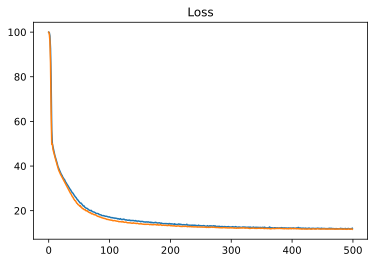

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [ ]:
model.load_weights('../working/best_model_car.hdf5')
model.save('../working/nn_1_car.hdf5')

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.68%


In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:, 0]
sample_submission.to_csv('nn1_submission.csv', index=False)

#### Начальные значение: TEST mape: 13.84%
#### Мои первые значение со стандартной структурой: TEST mape: 13.33%
#### Мои значения: TEST mape: 11.82%
#### Мои значения: TEST mape: 11.78%

## Итог
- Изменения Adam -> SGD не дали результатов 
- Изменения learning_rate не дали результатов
- Изменение слоёв не дало существенных результатов 

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422
(Выполнено но резуьаты ухудшились, пока не могу знать почему)

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений. (Выполнено)

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.(Выполнено)

- DropOut12=0.25 11.62%
- DropOut1=0.5 DropOut2=0.25  11.60%
- DropOut1=0.5 DropOut2=0.5  11.80%
------------------------------
- Adam=0.01, regularizer.l1_l2(l1=0.0001,l2=0.0001) 14.60%
- Adam=0.005, regularizer.l1_l2(l1=0.0001,l2=0.0001) 16.15%
- Adam=0.005, regularizer.l1_l2(l1=0.00001,l2=0.00001) 13.13%
- Adam=0.005, regularizer.l1_l2(l1=0.000001,l2=0.000001) 12.48%
- Adam=0.005, regularizer.l1_l2(l1=0.00000001,l2=0.00000001) 12.20%
- Adam=0.01, regularizer.l1_l2(l1=0.00000001,l2=0.00000001) 11.81%
- Adam=0.02, regularizer.l1_l2(l1=0.00000001,l2=0.00000001) 11.76%
- Adam=0.02, regularizer.l1_l2(l1=0.000000001,l2=0.000000001) 11.94%
- Adam=0.01, regularizer.l1_l2(l1=0.000000001,l2=0.000000001) 11.78%

#### Выводы:
Применение регуляризации избавляет нас от переобучения, и нет скачков MAPE во время обучения, сильно улучшить результат не получилось, но можно попробывать на итоговом обучении такую модель 

# Model 4: NLP + Multiple Inputs

In [ ]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

### Лемматизация

In [ ]:
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

#### В данной функции мы одновременно проводим лемматизацию и очистку теста от символов, что экономит нам время 

In [ ]:
# ∙–«»″“”➥₽№
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"


def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

##### Лемматизация всего датасета выполняется примерно 3.5 минуты, что относительно не долго 

In [ ]:
df_NLP['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

### Tokenizer

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
# split данных
text_train = df_NLP.description.iloc[X_train.index]
text_test = df_NLP.description.iloc[X_test.index]
text_sub = df_NLP.description.iloc[X_sub.index]

In [ ]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_NLP['description'])

In [ ]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'автомобиль': 5,
 'на': 6,
 'не': 7,
 'по': 8,
 'система': 9,
 'всё': 10,
 'пробег': 11,
 'задний': 12,
 'салон': 13,
 'сидение': 14,
 'год': 15,
 'состояние': 16,
 'для': 17,
 'передний': 18,
 'машина': 19,
 'от': 20,
 'до': 21,
 'при': 22,
 'диск': 23,
 'у': 24,
 'комплект': 25,
 'дилер': 26,
 'новый': 27,
 'официальный': 28,
 'без': 29,
 'ваш': 30,
 'кредит': 31,
 'вы': 32,
 'фара': 33,
 'авто': 34,
 'быть': 35,
 'руль': 36,
 'пакет': 37,
 'колесо': 38,
 'безопасность': 39,
 'комплектация': 40,
 'за': 41,
 'гарантия': 42,
 'птс': 43,
 'обмен': 44,
 'контроль': 45,
 'то': 46,
 'зеркало': 47,
 'проверка': 48,
 'из': 49,
 'покупка': 50,
 'весь': 51,
 'два': 52,
 'продажа': 53,
 'водитель': 54,
 'более': 55,
 'полный': 56,
 'есть': 57,
 'шина': 58,
 'км': 59,
 'датчик': 60,
 'отличный': 61,
 'пассажир': 62,
 'двигатель': 63,
 'так': 64,
 'резина': 65,
 'мы': 66,
 'условие': 67,
 'владелец': 68,
 'только': 69,
 'ключ': 70,
 'один': 71,
 'хороший': 72,

In [ ]:
len(tokenize.word_index)

14350

In [ ]:
% % time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.22 s, sys: 18 ms, total: 1.24 s
Wall time: 1.23 s


In [ ]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print('-----------------------------------------------')
print(text_train_sequences[6])

• автомобиль проверить по пункт • автокредит по специальный ставка от ауди центр север официальный дилер входящий в группа компания рольф и являться один из крупный дилер в европа предлагать вы ряд услуга по покупка и продажа автомобиль с пробег на протяжение многий год наш дилерский центр являться лидер по продажа автомобиль с пробег среди весь дилер в россия и предоставлять клиент самый большой выбор автомобиль с пробег и другой марка каждый автомобиль проходить тщательный диагностик и подготовка и гарантировать находиться в отличный состояние чтобы убедиться в правильный выбор у вы есть возможность пройти тест драйв ― ознакомительный поездка на интересовать автомобиль вы смочь ознакомиться с автомобиль не выходить из дом – наш менеджер провести презентация и в видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение по кредитование автомобиль с пробег на индивидуальный условие специалист компания подобрать для вы хороший условие кредитование

### RNN NLP
Нейронная сеть для текста (Description)

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, kernel_regularizer=regularizers.l1_l2(
    l1=0.000000001, l2=0.000000001), activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP
Нейронная сеть для табличных данных 

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(
    l1=0.000000001, l2=0.000000001), activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, kernel_regularizer=regularizers.l1_l2(
    l1=0.000000001, l2=0.000000001), activation="relu"))
model_mlp.add(L.Dropout(0.25))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3673856     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
______________________________________________________________________________________________

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model_car.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500
12/12 [==============================] - 38s 664ms/step - loss: 99.9982 - MAPE: 99.9982 - val_loss: 99.9321 - val_MAPE: 99.9321
Epoch 2/500
12/12 [==============================] - 7s 560ms/step - loss: 99.6648 - MAPE: 99.6648 - val_loss: 96.8187 - val_MAPE: 96.8186
Epoch 3/500
12/12 [==============================] - 7s 551ms/step - loss: 92.9099 - MAPE: 92.9099 - val_loss: 66.2657 - val_MAPE: 66.2656
Epoch 4/500
12/12 [==============================] - 6s 536ms/step - loss: 57.6160 - MAPE: 57.6159 - val_loss: 55.2932 - val_MAPE: 55.2932
Epoch 5/500
12/12 [==============================] - 6s 534ms/step - loss: 52.1326 - MAPE: 52.1326 - val_loss: 47.9579 - val_MAPE: 47.9578
Epoch 6/500
12/12 [==============================] - 6s 533ms/step - loss: 46.9141 - MAPE: 46.9141 - val_loss: 44.9323 - val_MAPE: 44.9322
Epoch 7/500
12/12 [==============================] - 6s 530ms/step - loss: 44.1328 - MAPE: 44.1327 - val_loss: 42.5847 - val_MAPE: 42.5846
Epoch 8/500
12/12 [=======

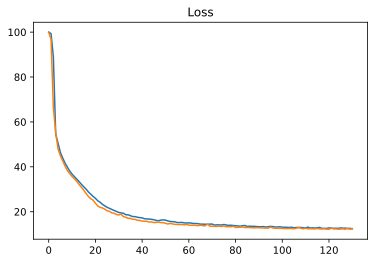

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [ ]:
model.load_weights('../working/best_model_car.hdf5')
model.save('../working/nn_mlp_nlp_car.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.46%


In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv('nn2_submission_car.csv', index=False)

#### Начальный результат: TEST mape: 14.61%
## Примечание: 
- В теории рультат должен быть лучше чем в прошлой модели 

#### Мой первый результат со стандартной моделью: TEST mape: 12.31%
#### Добавление лемматизации: TEST mape: 11.96%
#### Добавление новой лемматизации: TEST mape: 13.26%
#### Для табличных данных взята нейронка с прошлого шага: TEST mape: 12.43%
#### Убрал из лемматизации ∙–«»″“”➥₽№ : TEST mape: 12.26%
#### Добавил в RNN NLP регуляризацию regularizers.l1_l2(l1=0.000000001,l2=0.000000001): TEST mape: 12.35%
#### Изменил DropOut2 в NLP на 0.5 : TEST mape: 12.25%


Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/ (Выполнено)
* Поработать над алгоритмами очистки и аугментации текста (Выполнено частично в процессе лемматизации)

# Model 5: Добавляем картинки

### Data

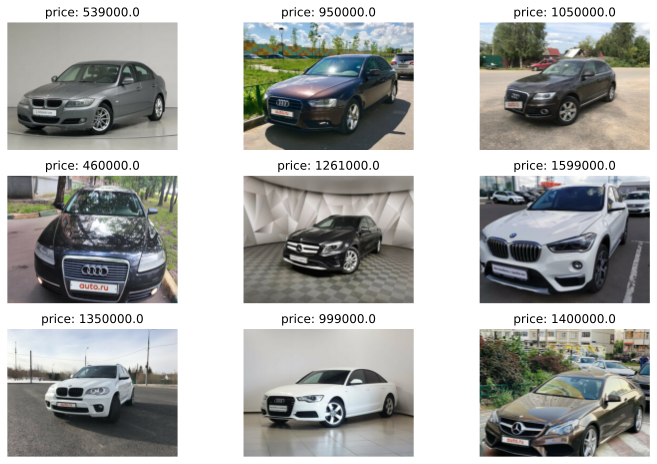

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)


def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

#images_train = get_image_array(X_train.index)
#images_test = get_image_array(X_test.index)
#images_sub = get_image_array(X_sub.index)

### Операция выше выполняется достаточно долго, поэтому в папку с проектом сохраним готовые матрицы, для дальнейшего использования
Далее просто подгружаем данные матрицы в решение

In [ ]:
# Сохранение матриц
#np.save(DATA_DIR+'images_train', images_train)
#np.save(DATA_DIR+'images_test', images_test)
#np.save(DATA_DIR+'images_sub', images_sub)

# Подгружаем матрицы в решение
images_train = np.load(DATA_DIR+'images_train.npy')
images_test = np.load(DATA_DIR+'images_test.npy')
images_sub = np.load(DATA_DIR+'images_sub.npy')

### albumentations

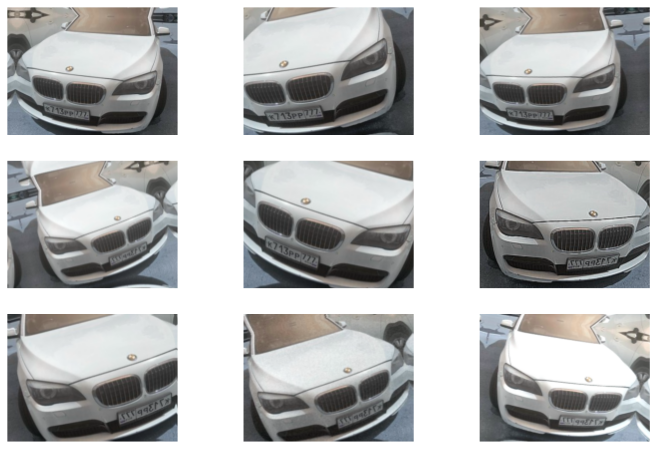

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, ChannelShuffle,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightness, OneOf, Compose, Rotate, RandomContrast,
    HorizontalFlip, RGBShift, RandomBrightnessContrast
)


# пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
"""augmentation = Compose([
            RandomBrightness(limit=0.4),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.6),
            HorizontalFlip(),
            CLAHE(p=0.2),
            Blur(p=0.1),
            HueSaturationValue(p=0.6),
            IAAPerspective(p=0.2),
            OpticalDistortion(p=0.2),
            #ChannelShuffle(p=1),
            RGBShift(p=1),
], p=1)"""

augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
                     rotate_limit=15, p=1),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_NLP.description)

In [ ]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, df_NLP.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, df_NLP.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, df_NLP.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

### Строим сверточную сеть для анализа изображений без "головы"

In [ ]:
# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [ ]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, l2=0.000000001), activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, l2=0.000000001), activation="relu"),
    L.Dropout(0.25),
])

In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.5),
    L.Dense(64, kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, l2=0.000000001), activation="relu"),
    L.Dropout(0.25)
])

In [ ]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, kernel_regularizer=regularizers.l1_l2(
    l1=0.000000001, l2=0.000000001), activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 320, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 240, 320, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(10),
                    epochs=40,
                    validation_data=test_dataset.batch(10),
                    callbacks=callbacks_list
                    )

Epoch 1/40
568/568 [==============================] - 460s 769ms/step - loss: 57.5293 - MAPE: 57.5292 - val_loss: 28.5881 - val_MAPE: 28.5880
Epoch 2/40
568/568 [==============================] - 436s 768ms/step - loss: 28.9862 - MAPE: 28.9860 - val_loss: 21.0476 - val_MAPE: 21.0474
Epoch 3/40
568/568 [==============================] - 434s 763ms/step - loss: 22.6150 - MAPE: 22.6149 - val_loss: 19.4431 - val_MAPE: 19.4429
Epoch 4/40
568/568 [==============================] - 436s 766ms/step - loss: 20.2619 - MAPE: 20.2617 - val_loss: 17.0446 - val_MAPE: 17.0444
Epoch 5/40
568/568 [==============================] - 433s 762ms/step - loss: 19.1783 - MAPE: 19.1781 - val_loss: 16.5893 - val_MAPE: 16.5890
Epoch 6/40
568/568 [==============================] - 435s 766ms/step - loss: 18.0345 - MAPE: 18.0342 - val_loss: 15.8157 - val_MAPE: 15.8153
Epoch 7/40
568/568 [==============================] - 432s 759ms/step - loss: 17.4697 - MAPE: 17.4693 - val_loss: 15.8377 - val_MAPE: 15.8372
Epoch 

KeyboardInterrupt: ignored

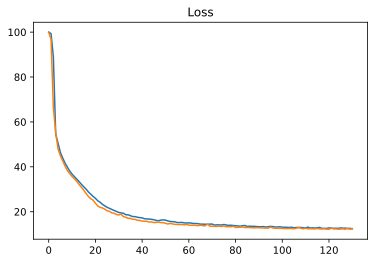

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.97%


In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission.to_csv('nn3_submission.csv', index=False)

####  Начальный результат: TEST mape: 13.39%
#### Мой первый результат измененной аугментацией, по улучшенным прошлым резуьтатом: TEST mape: 13.66% (25 поколений)
#### Мой результат c исходной аугментацией, по улучшенным прошлым резуьтатом: TEST mape: 13.20% (25 поколений) время ~ 3h
#### Добавление всех измененных сетей в решение, Adam=0.005: TEST mape: 12.97%% (28 поколений), время ~3h


# Blend

11.33 %

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:, 0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.29%


In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:, 0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_DIR+'blend_submission.csv', index=False)

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:, 0]) / 2
sample_submission['price'] = blend_sub_predict*0.98
sample_submission.to_csv(
    DATA_DIR+'blend_submission_correct_098.csv', index=False)

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(
    len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate, ])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_20_input (InputLayer)     [(None, 186)]        0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 512)          95744       dense_20_input[0][0]             
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 512)          0           dense_20[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(
                        [X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500
12/12 [==============================] - 1s 38ms/step - loss: 99.9942 - MAPE: 99.9942 - val_loss: 99.8072 - val_MAPE: 99.8072
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 99.1698 - MAPE: 99.1698 - val_loss: 92.9108 - val_MAPE: 92.9108
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 85.2044 - MAPE: 85.2044 - val_loss: 50.5071 - val_MAPE: 50.5071
Epoch 4/500
12/12 [==============================] - 0s 9ms/step - loss: 52.2705 - MAPE: 52.2705 - val_loss: 47.9693 - val_MAPE: 47.9693
Epoch 5/500
12/12 [==============================] - 0s 9ms/step - loss: 48.0520 - MAPE: 48.0520 - val_loss: 45.6085 - val_MAPE: 45.6085
Epoch 6/500
12/12 [==============================] - 0s 12ms/step - loss: 45.4061 - MAPE: 45.4061 - val_loss: 43.2558 - val_MAPE: 43.2558
Epoch 7/500
12/12 [==============================] - 0s 10ms/step - loss: 42.9180 - MAPE: 42.9180 - val_loss: 41.0066 - val_MAPE: 41.0066
Epoch 8/500
12/12 [=================

In [ ]:
model.load_weights('/working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.78%


## Результаты: 

1. CatBoost MAPE = 11.77%
2. Tabular NN MAPE = 11.86%
3. NLP + NN MAPE = 12.46%
4. NLP + NN MAPE + Picture MAPE = 12.97%
5. Blend result MAPE = 11.29% 

KAGGLE result = 12.52156%

# Выводы:
#### CatBoost
  В целом тут все хорошо, возможно результат может улучшить добавление новых фич, но пока нет идей что можно еще добавить 
#### Tabular NN
  Пробовал изменять структуру нейронной сети, но это не дало каких то положительных резьтатов, но зато добавление регуляризации l1_l2 доло более стабильный результат 
####  NLP + NN MAPE
  Можно еще поработать над выделением из текста схожих блоков и их замены для дальнейшего использования, но не успел это реализовать 
####  NLP + NN MAPE + Picture MAPE
  Пробовал разморозить половину весов в EfficientNetB3, но сеть обучалось очень долго и в итоге это не дало улучшения результата + пробовал сеть  EfficientNetB6, но время обучения увеличилось ~ в 3 раза, но результат не улучшился, добавление головы над базовой моделью тоже не дало улучшения результата 

## Есть куда стремиться и что исследовать дальше   